In [1]:
import json
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

## calculate count for apfp

In [2]:
pns_apfp = pd.Series.from_csv("fp_files/pns_apfp.csv", sep="\t", header=0) 

pns_apfp_counter = Counter()
for apfp_str in pns_apfp:
    apfp = json.loads(apfp_str)
    pns_apfp_counter.update(apfp.keys())
    
pns_apfp_count = pd.Series(pns_apfp_counter)
pns_apfp_count.index.name = "APFP"
pns_apfp_count.name = "COUNT"
pns_apfp_count.to_csv("fp_files/pns_apfp_count.csv", header=True)

In [3]:
cancer_approved_target = ["CHEMBL279", "CHEMBL203", "CHEMBL333", "CHEMBL325", "CHEMBL267", "CHEMBL2842"]
cancer_clinical_target = ["CHEMBL340", "CHEMBL4005", "CHEMBL332"]
target_list = cancer_approved_target + cancer_clinical_target

In [4]:
inh_apfp = pd.Series.from_csv("fp_files/inhibitor_apfp.csv", sep="\t", header=0)

for target in target_list:
    clf_label = pd.read_csv("chembl_source/%s_clf_label.csv" % target)
    target_apfp = inh_apfp.loc[clf_label["CMPD_CHEMBLID"].values]
    target_apfp_counter = Counter()
    for apfp_str in target_apfp:
        apfp = json.loads(apfp_str)
        target_apfp_counter.update(apfp.keys())
    target_apfp_count = pd.Series(target_apfp_counter)
    target_apfp_count.index.name = "APFP"
    target_apfp_count.name = "COUNT"
    target_apfp_count.to_csv("fp_files/%s_apfp_count.csv" % target, header=True)

## pick a threshold for minimun count of apfp

In [5]:
cancer_approved_target = ["CHEMBL279", "CHEMBL203", "CHEMBL333", "CHEMBL325", "CHEMBL267", "CHEMBL2842"]
cancer_clinical_target = ["CHEMBL340", "CHEMBL4005", "CHEMBL332"]
target_list = cancer_approved_target + cancer_clinical_target

In [6]:
inh_apfp = pd.Series.from_csv("fp_files/inhibitor_apfp.csv", sep="\t", header=0)

In [7]:
pns_count = pd.Series.from_csv("fp_files/pns_apfp_count.csv", header=0)

In [8]:
def sparse_features(fps_series, target_apfp_picked):
    columns_dict = defaultdict(lambda : len(target_apfp_picked))
    for i, apfp in enumerate(target_apfp_picked):
        columns_dict[apfp] = i
    data = []
    indices = []
    indptr = [0]
    for _, fps in fps_series.iteritems():
        n = indptr[-1]
        for k, v in fps.items():
            indices.append(columns_dict[k])
            data.append(v)
            n += 1
        indptr.append(n)
    a = sparse.csr_matrix((np.array(data), indices, indptr), shape=(len(fps_series), len(target_apfp_picked) + 1))
    return a

In [9]:
target = "CHEMBL279"

In [10]:
target_clf_label = pd.read_csv("chembl_source/%s_clf_label.csv" % target)
target_apfp_str = inh_apfp.loc[target_clf_label["CMPD_CHEMBLID"].values]
target_apfp = target_apfp_str.apply(json.loads)

In [20]:
target_count = pd.Series.from_csv("fp_files/%s_apfp_count.csv" % target, header=0)

In [22]:
count_threshold = 50

In [24]:
for count_threshold in range(10, 200, 20):
    print count_threshold
    pns_m = pns_count > count_threshold
    print pns_m.shape, pns_m.sum()

    count = target_count.add(pns_count, fill_value=0)
    m = count > count_threshold
    picked = count.loc[m]
    print target, picked.shape[0] - pns_m.sum()
    target_apfp_picked = picked.index.astype(str)

    a = sparse_features(target_apfp, target_apfp_picked)

    aa = a.toarray()[:, :-1]

    b = np.corrcoef(aa)

    c = (abs(b) > 0.9).astype(int) - np.eye(a.shape[0], dtype=int)
    print 0.9, c.sum() / 2.0
    c = (abs(b) > 0.95).astype(int) - np.eye(a.shape[0], dtype=int)
    print 0.95, c.sum() / 2.0
    c = (abs(b) > 0.99).astype(int) - np.eye(a.shape[0], dtype=int)
    print 0.99, c.sum() / 2.0
    c = (abs(b) > 0.999999).astype(int) - np.eye(a.shape[0], dtype=int)
    
    id_list = []
    for i, j in zip(*c.nonzero()):
        if i <= j:
            continue
        li = target_clf_label.iloc[i]["CLF_LABEL"]
        lj = target_clf_label.iloc[j]["CLF_LABEL"]
        if (li>0) != (lj>0):
            idi = target_clf_label.iloc[i]["CMPD_CHEMBLID"]
            idj = target_clf_label.iloc[j]["CMPD_CHEMBLID"]
            id_list.append(idi)
            id_list.append(idj)
            print (idi, li), (idj, lj)
            print "\n"

10
(21160,) 11504
CHEMBL279 168
0.9 52006.0
0.95 11212.0
0.99 149.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


30
(21160,) 8803
CHEMBL279 161
0.9 51948.0
0.95 11216.0
0.99 147.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


50
(21160,) 7661
CHEMBL279 178
0.9 52027.0
0.95 11238.0
0.99 147.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


70
(21160,) 6916
CHEMBL279 158
0.9 52269.0
0.95 11286.0
0.99 148.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


90
(21160,) 6363
CHEMBL279 152
0.9 52449.0
0.95 11347.0
0.99 148.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


110
(21160,) 5927
CHEMBL279 148
0.9 52492.0
0.95 11352.0
0.99 149.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


130
(21160,) 5583
CHEMBL279 145
0.9 52548.0
0.95 11373.0
0.99 152.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


150
(21160,) 5310
CHEMBL279 141
0.9 52617.0
0.95 11384.0
0.99 152.0
('CHEMBL511563', 1.0) ('CHEMBL502351', -1.0)


170
(21160,) 5093
CHEMBL279 126
0.9 52722.0
0.95 11433.0
0.99 152.0
('CHEMBL511563',

## check molecules' collision 

In [25]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [28]:
inh_smi = pd.Series.from_csv("structure_files/inhibitor_smiles.csv", header=0)

In [29]:
ms = [Chem.MolFromSmiles(inh_smi.loc[id_]) for id_ in id_list]

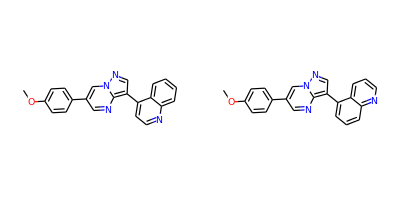

In [30]:
Draw.MolsToGridImage(ms, molsPerRow=2)